In [1]:
import metview as mv
import xarray as xr
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

This notebook is additional material and uses the `metview` library to plot and work with the ERA5 weather data. It was used for exploration and required a `.grib` file to be uploaded. Due to the size of the file, it is not included in the notebook.

### Loading and describing the data

In [13]:
filename = "../data/era5/full_era5_data.grib"
if mv.exist(filename):
    fs = mv.read(filename)
else:
    fs = mv.gallery.load_dataset(filename)

print(fs)
print(len(fs))

Fieldset (38350 fields)
38350


In [240]:
fs.describe()

parameter,typeOfLevel,level,date,time,step,paramId,class,stream,type,experimentVersionNumber
10u,surface,0,"19970101,19970102,...",1200,0,165,ea,enda,em,0001
10v,surface,0,"19970101,19970102,...",1200,0,166,ea,enda,em,0001
2t,surface,0,"19970101,19970102,...",1200,0,167,ea,enda,em,0001
mwd,meanSea,0,"19970101,19970102,...",1200,0,140230,ea,ewda,em,0001
tp,surface,0,"19970101,19970102,...",600,6,228,ea,enda,em,0001


In [242]:
fs[210:220].ls(extra_keys=['name', 'units'])

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,gridType,name,units
Message,,,,,,,,,,,
0,ecmf,10u,surface,0,19970212,1200,0,em,regular_ll,10 metre U wind component,m s**-1
1,ecmf,10v,surface,0,19970212,1200,0,em,regular_ll,10 metre V wind component,m s**-1
2,ecmf,2t,surface,0,19970212,1200,0,em,regular_ll,2 metre temperature,K
3,ecmf,mwd,meanSea,0,19970212,1200,0,em,regular_ll,Mean wave direction,Degree true
4,ecmf,tp,surface,0,19970212,600,3-6,em,regular_ll,Total precipitation,m
5,ecmf,10u,surface,0,19970213,1200,0,em,regular_ll,10 metre U wind component,m s**-1
6,ecmf,10v,surface,0,19970213,1200,0,em,regular_ll,10 metre V wind component,m s**-1
7,ecmf,2t,surface,0,19970213,1200,0,em,regular_ll,2 metre temperature,K
8,ecmf,mwd,meanSea,0,19970213,1200,0,em,regular_ll,Mean wave direction,Degree true


### Regridding

In [5]:
data_area = [-38, -163, -84,-12]
data_on_subarea = mv.read(data=fs, area=data_area)

Could not import ipywidgets module - animation widget will not appear
Call setoutput('jupyter', plot_widget=False) to suppress this message


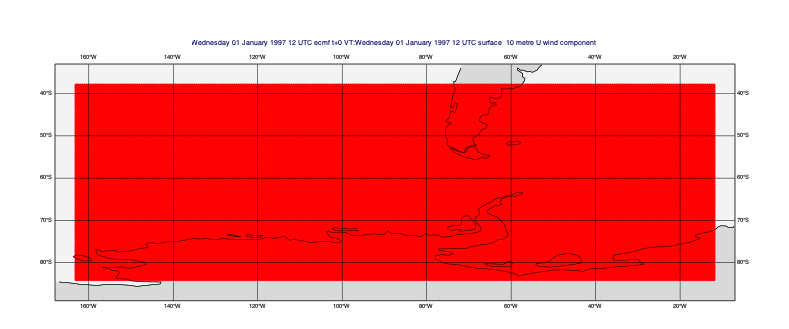

In [6]:
mv.setoutput('jupyter')
gridpoint_markers = mv.mcont(
    contour                          = "off",
    contour_grid_value_plot          = "on",
    contour_grid_value_plot_type     = "marker",
    contour_grid_value_marker_height = 0.2,
    contour_grid_value_marker_index  = 15,
    )

margins = [5, -5, -5, 5]
view_area = [a + b for a, b in zip(data_area, margins)]
coastlines = mv.mcoast(map_coastline_land_shade=True,
                       map_coastline_land_shade_colour="RGB(0.85,0.85,0.85)",
                       map_coastline_sea_shade=True,
                       map_coastline_sea_shade_colour="RGB(0.95,0.95,0.95)",)
view = mv.geoview(map_area_definition="corners", area=view_area, coastlines=coastlines)

mv.plot(view, data_on_subarea[0], gridpoint_markers)

Could not import ipywidgets module - animation widget will not appear
Call setoutput('jupyter', plot_widget=False) to suppress this message


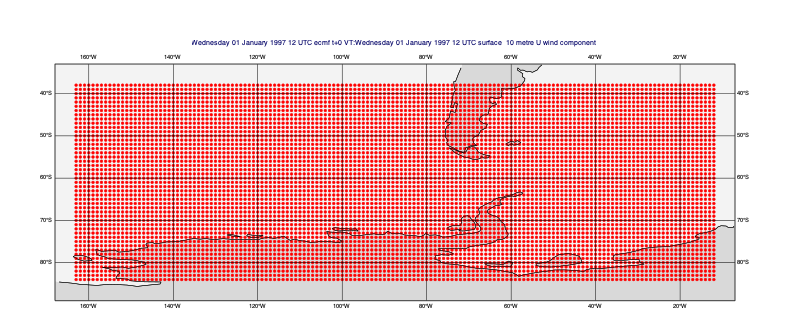

In [7]:
mv.setoutput('jupyter')
lowres_data = mv.read(data=data_on_subarea, grid=[1, 1]) # 1 degrees
mv.plot(view, lowres_data[0], gridpoint_markers)

In [257]:
# save lowres_data to a .grb file again
mv.write('../data/era5/lowres_era5.grib', lowres_data)

0.0

### Wind speed analysis

In [63]:
lowres_data = mv.read('../data/era5/lowres_era5.grib')

In [50]:
u = mv.read(data=lowres_data, param='10u')
v = mv.read(data=lowres_data, param='10v')

In [51]:
sp = mv.sqrt(u*u + v*v)

In [52]:
sp = mv.grib_set_long(sp, ['paramId', 10])
sp = mv.grib_set_string(sp, ['shortName', 'ws'])

Could not import ipywidgets module - animation widget will not appear
Call setoutput('jupyter', plot_widget=False) to suppress this message


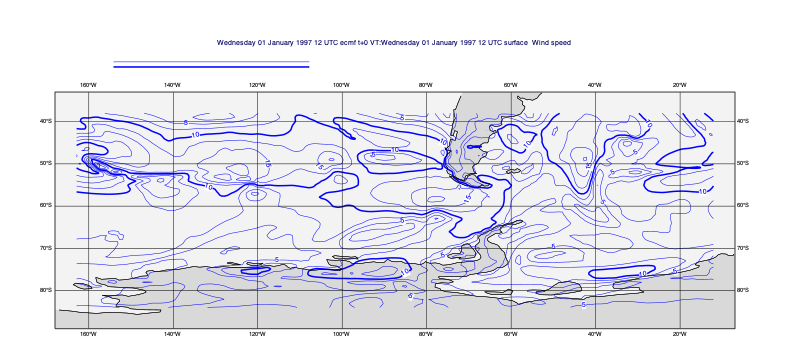

In [89]:
mv.setoutput('jupyter')
#mv.plot(sp, mv.mcont(contour_automatic_setting='ecmwf', legend='on'))

# plot only on the subarea
data_area = [-38, -163, -84,-12]

margins = [5, -5, -5, 5]
view_area = [a + b for a, b in zip(data_area, margins)]
coastlines = mv.mcoast(map_coastline_land_shade=True,
                       map_coastline_land_shade_colour="RGB(0.85,0.85,0.85)",
                       map_coastline_sea_shade=True,
                       map_coastline_sea_shade_colour="RGB(0.95,0.95,0.95)")#
view = mv.geoview(map_area_definition="corners", area=view_area, coastlines=coastlines)

sp_on_subarea = mv.read(data=sp, area=data_area)

mv.plot(view, sp_on_subarea[0], mv.mcont(contour_automatic_setting='ecmwf', legend='on'))


In [56]:
# save windspeed to a .grib file
mv.write("../data/era5/windspeed.grib", sp)
combined_grib = mv.merge(lowres_data, sp)

# Write to a new GRIB file
mv.write("../data/era5/combined_era5.grib", combined_grib)

0.0

### Precipation analysis

In [64]:
tp = mv.read(data=fs, param='tp')
#tp_gridded = mv.read(data=lowres_data, shortName='tp')
tp_gridded = mv.read(data=lowres_data, param='tp')


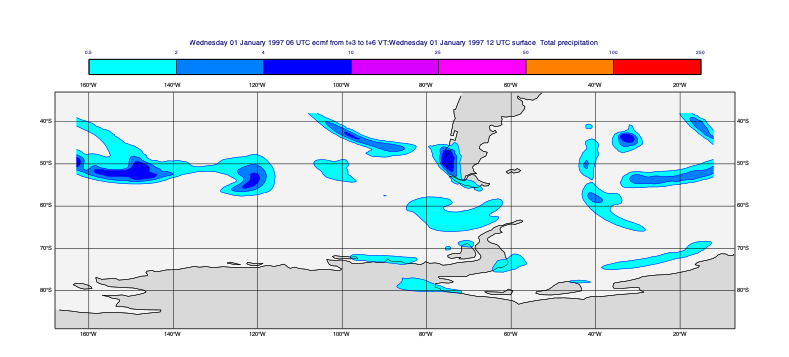

In [59]:
mv.plot(view, tp[0], mv.mcont(contour_automatic_setting='ecmwf', legend='on'))

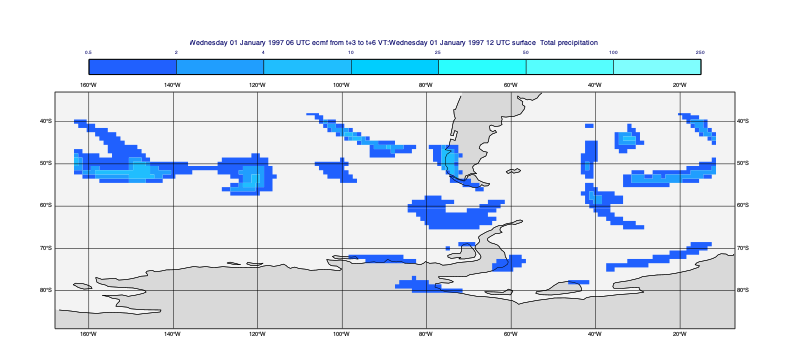

In [101]:
grid_shade = mv.mcont(
    legend                         = "on",
    contour                        = "off",
    contour_level_selection_type   = "level_list",
    contour_level_list             = [0.5,2,4,10,25,50,100,250],
    contour_shade                  = "on",
    contour_shade_technique        = "grid_shading",
    contour_shade_colour_method    = "palette",
    contour_shade_palette_name     = "norway_blue_red_16",
    grib_scaling_of_derived_fields = "on"
    )

mv.plot(view, tp_gridded[0], grid_shade)

### Interpolation: Nearest gridpoint and surrounding gridpoints

In [81]:
filename = "../data/era5/combined_era5.grib"
if mv.exist(filename):
    era5 = mv.read(filename)
else:
    era5 = mv.gallery.load_dataset(filename)

In [69]:
era5.describe()

parameter,typeOfLevel,level,date,time,step,paramId,class,stream,type,experimentVersionNumber
10u,surface,0,"19970101,19970102,...",1200,0,165,ea,enda,em,0001
10v,surface,0,"19970101,19970102,...",1200,0,166,ea,enda,em,0001
2t,surface,0,"19970101,19970102,...",1200,0,167,ea,enda,em,0001
mwd,meanSea,0,"19970101,19970102,...",1200,0,140230,ea,ewda,em,0001
tp,surface,0,"19970101,19970102,...",600,6,228,ea,enda,em,0001


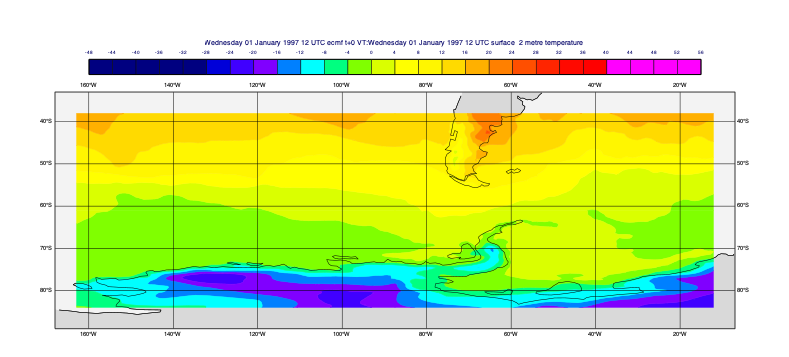

In [103]:
fs_2t = mv.read(data=fs, param='2t')
mv.plot(view, fs_2t[0], mv.mcont(contour_automatic_setting='ecmwf', legend='on'))

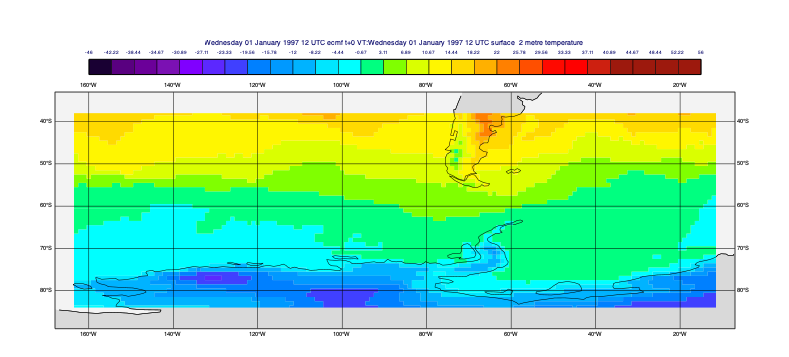

In [106]:
era5_2t = mv.read(data=era5, param='2t')

grid_shade = mv.mcont(
    legend                         = "on",
    contour                        = "off",
    contour_level_selection_type   = "level_list",
    contour_level_list             = [-46.0, -42.22, -38.44, -34.67, -30.89, -27.11, -23.33, -19.56, -15.78, -12.0, 
 -8.22, -4.44, -0.67, 3.11, 6.89, 10.67, 14.44, 18.22, 22.0, 25.78, 
 29.56, 33.33, 37.11, 40.89, 44.67, 48.44, 52.22, 56.0],
    contour_shade                  = "on",
    contour_shade_technique        = "grid_shading",
    contour_shade_colour_method    = "palette",
    contour_shade_palette_name     = "m_rainbow_purple_blue_red_24", 
    grib_scaling_of_derived_fields = "on"
    )
#""sh_all_fM64t52i4"

mv.plot(view, era5_2t[0], grid_shade)

### Testing NN interpolation

In [207]:
latitude, longitude = -63.401, -57.005
loc = [latitude, longitude]

idx = mv.surrounding_points_indexes(lowres_data[0], loc)

idx_int = np.asarray(idx, dtype=np.int32)
vals = mv.values(lowres_data[0])[idx_int]
lats = mv.latitudes(lowres_data[0])[idx_int]
lons = mv.longitudes(lowres_data[0])[idx_int]

for i in range(0, len(vals)):
    print('lat:{} lon:{} val:{}'.format(lats[i], lons[i], vals[i]))

lat:-63.0 lon:-57.0 val:8.095474243164062
lat:-64.0 lon:-57.0 val:2.0769195556640625
lat:-63.0 lon:-58.0 val:8.734146118164062
lat:-64.0 lon:-58.0 val:1.5720367431640625


In [204]:
# concat the lats and lons with loc
latitude, longitude = -63.401, -57.005
lats = np.concatenate((lats, [latitude]))
lons = np.concatenate((lons, [longitude]))
loc = list(zip(lats, lons))

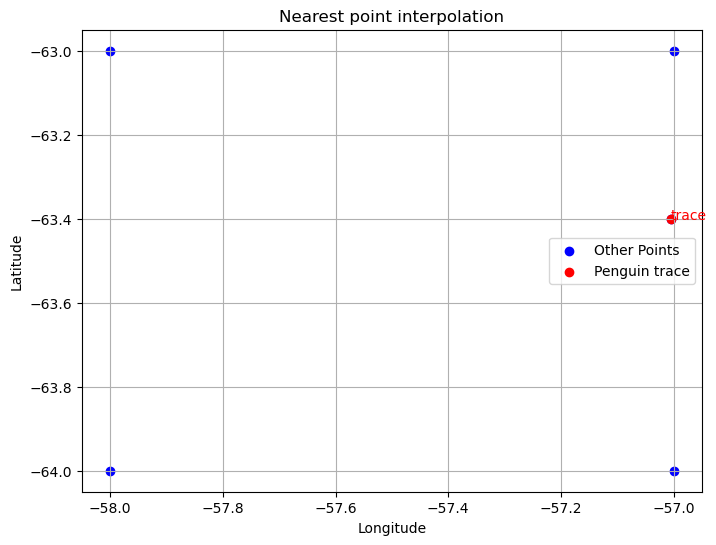

In [205]:
last_lat, last_lon = lats[-1], lons[-1]

# Plot the coordinates
plt.figure(figsize=(8, 6))
plt.scatter(lons, lats, color='blue', label='Other Points')
plt.scatter(last_lon, last_lat, color='red', label='Penguin trace')  

# Annotate the last point
plt.text(last_lon, last_lat, 'trace', color='red', fontsize=10)

# Add labels and grid
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Nearest point interpolation')
plt.grid(True)
plt.legend()
plt.show()

### Time series (Termperature development at colony 1)

In [42]:
penguin_df = pd.read_csv('../data/penguin/penguins_final.csv')
data = mv.read('../data/era5/lowres_era5.grib')

# get unique colony coordinates
colony_coords = penguin_df[['lat_colony', 'lon_colony']].drop_duplicates()
colony_coords = colony_coords.iloc[0]

In [44]:
t2m = data['2t'] - 273.16

col1_coords = [colony_coords['lat_colony'], colony_coords['lon_colony']]
col1_vals = t2m.nearest_gridpoint(col1_coords)

# extract the valid times for the data
times = mv.valid_date(t2m)

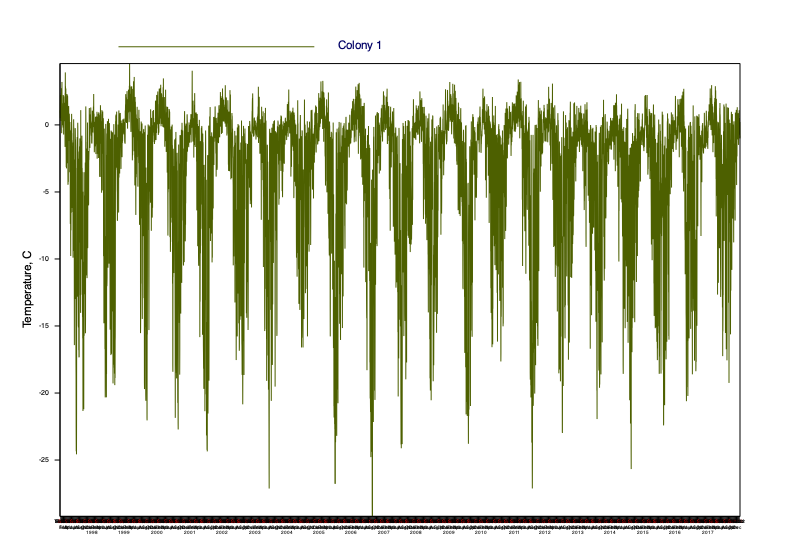

In [45]:
vaxis = mv.maxis(axis_title_text="Temperature, C", axis_title_height=0.5)

ts_view = mv.cartesianview(
    x_automatic="on",
    x_axis_type="date",
    y_automatic="on",
    vertical_axis=vaxis,
)

# create the curves for all locations
curve_col1 = mv.input_visualiser(
    input_x_type="date", input_date_x_values=times, input_y_values=col1_vals
)

# set up visual styling for each curve
common_graph = {"graph_line_thickness": 2, "legend": "on"}
graph_col1 = mv.mgraph(common_graph, graph_line_colour="olive", legend_user_text="Colony 1")

# customise the legend
legend = mv.mlegend(legend_display_type="disjoint", legend_text_font_size=0.5)

# plot everything into the Cartesian view
mv.plot(ts_view, curve_col1, graph_col1, legend)